In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# The age-metallicity structure of the Milky Way disk

This IPython notebook runs through all the necessary steps to reproduce the plots found in the Mackereth et al. (2017) paper. In order for the following code to work, the user must have pre-calculated the required isochrone grid (using make_isochrone_grids.py), the effective selection function for the mono-age, mono-[Fe/H] populations used for the paper (using calc_effsel_monoage.py) and then downloaded the relevant age and distance tables for the APOGEE-DR12 data (see readme), and placed these in the 'catalogues' directory.

The first section goes through the plots used in the Data section of the paper. The second section guides the user through the creation of the plots in sections 4 and 5 of the paper, which form the bulk of the science results.

## Section 1 - General Plots

In [2]:
try:
    reload(densprofiles)
    reload(define_rgbsample)
    reload(fitDens)
    reload(fitDens.densprofiles)
    reload(compareDataModel)
    reload(mockDensData)
except NameError:
    import densprofiles
    import define_rgbsample
    import fitDens
    import compareDataModel
    import mockDensData
%pylab inline
import numpy
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
import os, os.path
import pickle
import copy
from galpy.util import bovy_plot, bovy_coords
import mpl_toolkits.axisartist as AA
import corner
import mwdust
import fitsio
from scipy.interpolate import interp1d
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 14, 'font.family' : 'serif'}
plt.rcParams.update(params)


columnwidth = 240./72.27
textwidth = 504.0/72.27

selectFile= '../savs/selfunc-nospdata.sav'
if os.path.exists(selectFile):
    with open(selectFile,'rb') as savefile:
        apo= pickle.load(savefile)
with open('../essf/maps/essf_rgb_green15_modelmh_feh-0.0_age1.0.sav','rb') as savefile:
    locations= pickle.load(savefile)
    effsel= pickle.load(savefile)
    distmods= pickle.load(savefile)
with open('../essf/maps/essf_rgb_marshall06_modelmh_feh-0.0_age1.0.sav','rb') as savefile:
    mlocations= pickle.load(savefile)
    meffsel= pickle.load(savefile)
    mdistmods= pickle.load(savefile)
# Fill in regions not covered by Marshall map
meffsel[meffsel < -0.5]= effsel[meffsel < -0.5]

# Get (lcen,bcen) for each location
lcen= numpy.zeros(len(locations))
bcen= numpy.zeros(len(locations))
hmax= numpy.zeros(len(locations))
for ii,loc in enumerate(locations):
    if loc in apo.list_fields():
        tlcen, tbcen= apo.glonGlat(loc)
        lcen[ii]= tlcen
        bcen[ii]= tbcen
        hmax[ii]= apo.Hmax(loc,cohort='long')
        if numpy.isnan(hmax[ii]):
            hmax[ii]= apo.Hmax(loc,cohort='medium')
            if numpy.isnan(hmax[ii]):
                hmax[ii]= apo.Hmax(loc,cohort='short')
    if loc not in apo.list_fields():
        lcen[ii] = numpy.nan
        bcen[ii] = numpy.nan
        hmax[ii]= numpy.nan

# Get the locations of various subsamples
highbIndx= numpy.fabs(bcen) > 10.
outDiskIndx= (lcen > 150.)*(lcen < 250.)*(True-highbIndx)
betwDiskIndx= (lcen <= 150.)*(lcen >= 70.)*(True-highbIndx)
inDiskIndx= (lcen < 70.)*(lcen >= 25.)*(True-highbIndx)
bulgeIndx= ((lcen < 25.)+(lcen > 335.))*(True-highbIndx)
brightIndx= (hmax <= 12.21)
mediumIndx= (hmax > 12.21)*(hmax <= 12.81)
faintIndx= (hmax > 12.81)


ldata= None
data_highbIndx= None
data_outDiskIndx= None
data_betwDiskIndx= None
data_inDiskIndx= None
data_bulgeIndx= None
data_brightIndx= None
data_mediumIndx= None
data_faintIndx= None
def load_data(subsample='lowlow', add_ages=False, agebin=[0.,1.], fehbin=[0.,0.2], afebin=None, agetype='Martig', corrections=False):
    global ldata
    global data_highbIndx
    global data_outDiskIndx
    global data_betwDiskIndx
    global data_inDiskIndx    
    global data_bulgeIndx    
    global data_brightIndx
    global data_mediumIndx
    global data_faintIndx
    if subsample.lower() == 'all':
        ldata= define_rgbsample.get_rgbsample(agetype=agetype)
    elif subsample.lower() == 'alllowalpha':
        ldata= define_rgbsample.get_rgbsample()
        ldata= ldata[ldata[define_rgbsample._AFETAG] < 0.1]
    elif subsample.lower() == 'lowlow':
        ldata= define_rgbsample.get_lowlowsample()
    elif subsample.lower() == 'highfeh':
        ldata= define_rgbsample.get_highfehsample()
    elif subsample.lower() == 'highalpha':
        ldata= define_rgbsample.get_highalphasample()
    elif subsample.lower() == 'solar':
        ldata= define_rgbsample.get_solarsample()
    elif subsample.lower() == 'fehage':
        ldata= define_rgbsample.get_fehage(agebin=agebin, fehbin=fehbin, afebin=afebin, agetype=agetype, apply_corrections=corrections)
    # Get the indices of the various subsamples defined above
    data_highbIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[highbIndx]: data_highbIndx[ii]= True
    data_outDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[outDiskIndx]: data_outDiskIndx[ii]= True
    data_betwDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[betwDiskIndx]: data_betwDiskIndx[ii]= True
    data_inDiskIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[inDiskIndx]: data_inDiskIndx[ii]= True
    data_bulgeIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[bulgeIndx]: data_bulgeIndx[ii]= True
    data_brightIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[brightIndx]: data_brightIndx[ii]= True
    data_mediumIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[mediumIndx]: data_mediumIndx[ii]= True
    data_faintIndx= numpy.zeros(len(ldata),dtype='bool')
    for ii in range(len(ldata)):
        if ldata[ii]['LOCATION_ID'] in numpy.array(locations)[faintIndx]: data_faintIndx[ii]= True


Populating the interactive namespace from numpy and matplotlib
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.



In [10]:
load_data(subsample='fehage', fehbin=[-0.6,0.2], agebin=[0.,13.], agetype='Martig', corrections=True)
def alphaedge(fehs):
    edge = np.zeros(len(fehs))
    edge[fehs < 0] = (0.12/-0.6)*fehs[fehs < 0]+0.03
    edge[fehs >= 0] = 0.03
    return edge


### Figure 1 - the $\mathrm{[\alpha/Fe]}$-$\mathrm{[Fe/H]}$ distribution

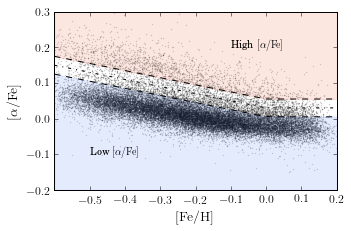

In [13]:

low = ldata['AVG_ALPHAFE'] <= alphaedge(ldata['FE_H']-0.025)
high = ldata['AVG_ALPHAFE'] > alphaedge(ldata['FE_H']+0.025)

fig = plt.figure()
fehs = np.linspace(-0.6, 0.2, 100)
plt.scatter(ldata['FE_H'], ldata['AVG_ALPHAFE'], s=2, alpha=0.2, edgecolor=None, color='black', lw=0.)
plt.plot(fehs, alphaedge(fehs)+0.025, color='black', linestyle='dashed')
plt.plot(fehs, alphaedge(fehs)-0.025, color='black', linestyle='dashed')
plt.plot(fehs, alphaedge(fehs), color='black', linestyle='dashdot')

plt.fill_between(fehs, alphaedge(fehs)+0.025, 0.3*np.ones(100), color=plt.cm.coolwarm(0.8), alpha=0.2)
plt.fill_between(fehs, -0.2*np.ones(100), alphaedge(fehs)-0.025, color=plt.cm.coolwarm(0.2), alpha=0.2)
plt.text(-0.1,0.2, r'High $\mathrm{[\alpha/Fe]}$')
plt.text(-0.5,-0.1, r'Low $\mathrm{[\alpha/Fe]}$')
plt.xlim(-0.6,0.2)
plt.ylim(-0.2,0.3)
plt.ylabel(r'$\mathrm{[\alpha/Fe]}$')
plt.xlabel(r'$\mathrm{[Fe/H]}$')
fig.set_size_inches(1.5*columnwidth, columnwidth)
fig.tight_layout()

### Figure 2 - the spatial distribution 

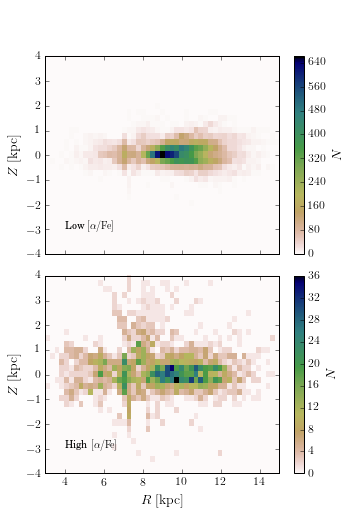

In [12]:
xbins = np.linspace(3.,15.,50)
ybins = np.linspace(-6.,6.,50)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
s1 = ax[0].hist2d(ldata['MH50_GALR'][low], ldata['MH50_GALZ'][low], bins=[xbins,ybins], cmap=plt.cm.gist_earth_r)
s2 = ax[1].hist2d(ldata['MH50_GALR'][high], ldata['MH50_GALZ'][high], bins=[xbins,ybins], cmap=plt.cm.gist_earth_r)
ax[0].set_xlim(3.,15.)
ax[0].set_ylim(-4.,4.)
ax[0].set_ylabel(r'$Z\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$Z\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$R\ \mathrm{[kpc]}$')
#ax[0].set_xlabel(r'$R\ \mathrm{[Kpc]}$')
ax[0].text(4,-3, r'Low $\mathrm{[\alpha/Fe]}$')
ax[1].text(4,-3, r'High $\mathrm{[\alpha/Fe]}$')

plt.colorbar(s1[3], ax=ax[0], label=r'$N$')
plt.colorbar(s2[3], ax=ax[1], label=r'$N$')


fig.set_size_inches(1.5*columnwidth, 2*columnwidth)
fig.tight_layout()

### Figure 3 - Red-Clump distance comparison

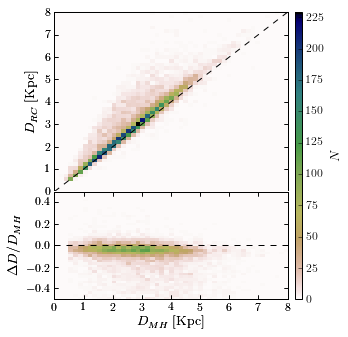

In [16]:
import define_rcsample
from astropy.table import Table, join
import mpl_toolkits.axisartist as AA 

dat = define_rcsample.get_rcsample()
ldat = define_rgbsample.get_rgbsample(add_ages=True)
rctab = Table(data=dat)
fulltab = Table(data=ldat)
tab = join(rctab,fulltab, keys='APOGEE_ID', uniq_col_name='{col_name}{table_name}', table_names=['RCLUMP',''])
distcomp = tab.as_array()


fig = plt.figure()
x = np.linspace(0.,8.,50)
y = np.linspace(0.,8.,50)

glatmask = (np.fabs(distcomp['GLAT']) > 6.)&(distcomp['FE_H'] >= -0.6)&(distcomp['FE_H'] <0.2)&(distcomp['Age'] < 13.)

ax1 = AA.Axes(fig,[0.2,0.45,0.65,0.5])
fig.add_axes(ax1)
s = ax1.hist2d(10**((distcomp['HAYDEN_DISTMOD_50']+5.)/5.)/1e3, 10**((distcomp['RC_DM_H']+5.)/5.)/1e3, bins=[x,y], cmap=plt.cm.gist_earth_r)

ax1.plot(x,y, color='Black', linestyle='dashed')
#
ax1.set_ylabel(r'$D_{RC}\ \mathrm{[Kpc]}$')
ax1.set_xticks([])

#ax1.set_ylim(-0.5,1.3)
ax2 = AA.Axes(fig,[0.2,0.15,0.65,0.3])
fig.add_axes(ax2)
x = 10**((distcomp['HAYDEN_DISTMOD_50']+5.)/5.)/1e3
y = 10**((distcomp['RC_DM_H']+5.)/5.)/1e3
delta = x-y
xbins = np.linspace(0.,8.,50)
ybins = np.linspace(-0.6,0.6,50)
ax2.hist2d(y,delta/x, bins=[xbins,ybins], cmap=plt.cm.gist_earth_r, vmin=0.,vmax=225.)
ax2.axhline(0, color='Black', linestyle='dashed')
ax2.set_ylabel(r'$\Delta D / D_{MH}$')
ax2.set_xlabel(r'$D_{MH}\ \mathrm{[Kpc]}$')
ax1.legend(loc=4)
ax2.set_ylim(-0.5,0.5)
ax2.set_yticks([-0.4,-0.2,0.,0.2,0.4])
#ax1.set_yticks([-0.4,0.,0.4,0.8,1.2])
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
cax = fig.add_axes([0.87,0.15,0.02,0.8])
plt.colorbar(s[3], cax=cax, label=r'$N$')

### Figure 4 - Age correction fit 

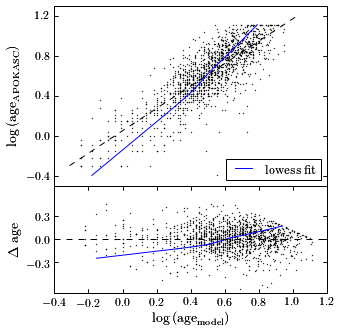

In [21]:
table = np.genfromtxt('../catalogues/martig2016_table1.txt', dtype=None, names=True, skip_header=2)
fig = plt.figure()
ax1 = AA.Axes(fig,[0.2,0.45,0.76,0.5])
fig.add_axes(ax1)
ax1.scatter(np.log10(table['Age_out']),np.log10(table['Age_in']), s=2, alpha=0.8, lw=0., color='Black')
xs = np.linspace(-0.3,1.2,100)
xsinterpolate = interp1d(xs,xs)
ax1.plot(xs,xs, color='Black', linestyle='dashed')
fit = lowess(np.log10(table['Age_out']),np.log10(table['Age_in']))#, delta=0.01, frac=0.5 )
ax1.plot(fit[:,1], fit[:,0], label='lowess fit')
#
ax1.set_ylabel(r'$\mathrm{\log{(age_{APOKASC})}}$')
ax1.set_xticks([])
fig.set_size_inches(columnwidth,columnwidth)
ax1.set_ylim(-0.5,1.3)
ax2 = AA.Axes(fig,[0.2,0.15,0.76,0.3])
fig.add_axes(ax2)
ax2.plot(fit[:,1], fit[:,0]-xsinterpolate(fit[:,1]))
ax2.scatter(np.log10(table['Age_out']),((np.log10(table['Age_in'])-np.log10(table['Age_out']))), s=2, alpha=0.8, lw=0., color='Black')
ax2.axhline(0, color='Black', linestyle='dashed')
ax2.set_ylabel(r'$\mathrm{\Delta\ age}$')
ax2.set_xlabel(r'$\mathrm{\log{(age_{model})}}$')
ax1.legend(loc=4)
ax2.set_ylim(-0.7,0.7)
ax2.set_yticks([-0.3,0.,0.3])
ax1.set_yticks([-0.4,0.,0.4,0.8,1.2])
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)


### Figure 5 - Raw star counts

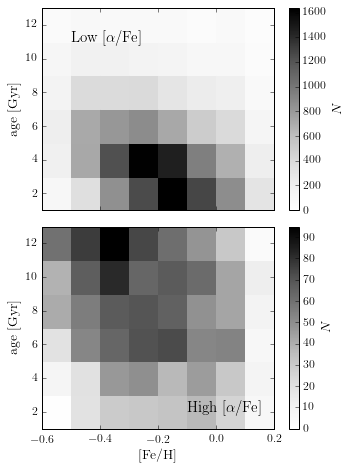

In [22]:
agebins = np.arange(1.,14.,2.)
fehbins = np.arange(-0.6,0.3,0.1)

hc_numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='highclean', agetype='Martig', corrections=True)
dat = ldata#[data_medbIndx]
for j in range(0,len(fehbins)-1):
    numbinfeh = []
    for i in range(0,len(agebins)-1):
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        ldata = dat[mask]
        num_bin = len(ldata)
        numbinfeh.append(num_bin)
    hc_numbins.append(numbinfeh)
hc_numbins = np.array(hc_numbins)

lc_numbins = []
load_data(subsample='fehage', add_ages=True, agebin=[0., 13.], fehbin=[-0.6,0.2], afebin='lowclean', agetype='Martig', corrections=True)
dat = ldata#[data_medbIndx]
for j in range(0,len(fehbins)-1):
    numbinfeh = []
    for i in range(0,len(agebins)-1):
        mask = (dat['Age'] >= agebins[i])&(dat['Age'] < agebins[i+1])&(dat['FE_H'] >= fehbins[j])&(dat['FE_H'] < fehbins[j+1])
        ldata = dat[mask]
        num_bin = len(ldata)
        numbinfeh.append(num_bin)
    lc_numbins.append(numbinfeh)
lc_numbins = np.array(lc_numbins)

hc_nums = hc_numbins.ravel()
lc_nums = lc_numbins.ravel()
norm = mpl.colors.Normalize(vmin=0., vmax=max(lc_nums))
norm2 = mpl.colors.Normalize(vmin=0., vmax=max(hc_nums))
cmap = mpl.cm.Greys
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m2 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm2)
s_m.set_array([])
s_m2.set_array([])

fig, ax  = plt.subplots(2,1, sharex=True, sharey=True)
for j in range(0, len(fehbins)-1):
    for i in range(0,len(agebins)-1):
        hz = lc_numbins[j,i]
        xedges = [fehbins[j], fehbins[j+1]]
        yedgelow = [agebins[i], agebins[i]]
        yedgehigh = [agebins[i+1], agebins[i+1]]
        ax[0].fill_between(xedges, yedgelow,yedgehigh, color=s_m.to_rgba(hz))
         

for j in range(0, len(fehbins)-1):
    for i in range(0,len(agebins)-1):
        dhz = hc_numbins[j,i]
        xedges = [fehbins[j], fehbins[j+1]]
        yedgelow = [agebins[i], agebins[i]]
        yedgehigh = [agebins[i+1], agebins[i+1]]
        ax[1].fill_between(xedges, yedgelow,yedgehigh, color=s_m2.to_rgba(dhz))
           
               
#titles and axes
plt.ylim(1.,13.)
plt.xlim(-0.6,0.2)
ax[0].set_ylabel(r'$\mathrm{age}\ \mathrm{[Gyr]}$')
ax[1].set_ylabel(r'$\mathrm{age}\ \mathrm{[Gyr]}$')
#ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
plt.colorbar(s_m, label=r'$N$', ax= ax[0])
plt.colorbar(s_m2, label=r'$N$', ax=ax[1])
ax[0].set_xticks([-0.6,-0.4,-0.2,-0.,0.2])
ax[0].text(-0.5,11,r'$\mathrm{Low\ [\alpha/Fe]}$', fontsize=15)
ax[1].text(-0.1,2,r'$\mathrm{High\ [\alpha/Fe]}$', fontsize=15)
fig.subplots_adjust(wspace=0.2)
fig.set_size_inches(1.5*columnwidth,2*columnwidth)
fig.tight_layout()



## Section 2 - Results & Discussion

The plots here require a little more complicated code so the following cells are quite long (you can turn off raw code using the button at the top of the notebook). You have to have run the fit_monoage.py and mass_script.py codes (see README) in order to have the results files saved in the ../savs directory - these cells wont work without them.

The systematic errors in figures 10 and 11 arise mostly due to differences in the Log(g) scale of the stellar evolution models and APOGEE - these are precalculated by performing the mass calculations (in mass_script.py) with the stellar models Log(g) shifted by $\pm 0.3$ dex. Users can perform these calculations if necessary by adjusting the loggcut parameter in mass_script.py. For simplicity, this run-through does not explicitly include these calculations. 


In [28]:
savfile = open('../savs/paramsRGB_brokenexpflare_01dex2gyrbins_low_mass.dat', 'rb')
obj = pickle.load(savfile)
lagebins, lfehbins, lnumbins, lparamt, lsamples, lmassgrid, lm_samplegrid = obj

savfile = open('../savs/paramsRGB_brokenexpflare_01dex2gyrbins_high_mass.dat', 'rb')
obj = pickle.load(savfile)
hagebins, hfehbins, hnumbins, hparamt, hsamples, hmassgrid, hm_samplegrid = obj

def floating_axis(fig, position, invisible=True):
    inax = AA.Axes(fig, position)
    fig.add_axes(inax)
    if invisible == True:
        inax.axis["right","left","top"].set_visible(False)
    return inax

def conv_data_position(fig,ax, position):
    disp_pos = ax.transData.transform(position)
    inv = fig.transFigure.inverted()
    return inv.transform(disp_pos)

_SKIP = 10
_SIGNIF = 0.025
Rs = np.linspace(3.,15.,1001)
ages = [2,4,6,8,10,12]
cmap = plt.get_cmap('viridis')
y = np.arange(-0.6,0.3,0.1)

def surfdens_plot(samp,mgrid, hi_fullmgrid, lo_fullmgrid, ax, inv_ihRin=True, numbins= None, ntol=30, fage=True, alpha_norm='column'):
    overplot=True
    for ii, map in enumerate(samp):
        if numbins != None:
            if numbins[ii] < ntol:
                continue
        # Create all density profiles
        tsamp= samp[ii,:,::_SKIP]
        nsamples= len(tsamp[0])
        tRs= numpy.tile(Rs,(nsamples,1)).T
        ldp= numpy.empty((len(Rs),nsamples))
        Rb= numpy.tile(numpy.exp(tsamp[3]),(len(Rs),1))
        ihRin= numpy.tile(tsamp[0],(len(Rs),1))
        if inv_ihRin == True:
            ihRin = -numpy.tile(tsamp[0],(len(Rs),1))
        ihRout= numpy.tile(tsamp[2],(len(Rs),1))
        # Rb >= R0
        leRb= (tRs <= Rb)*(Rb >= densprofiles._R0)
        ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)
        gtRb= (tRs > Rb)*(Rb >= densprofiles._R0)
        ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)\
            +ihRout[gtRb]*(Rb[gtRb]-densprofiles._R0)\
            +ihRin[gtRb]*(Rb[gtRb]-densprofiles._R0)
        # Rb < R0, normalize outer at R0
        leRb= (tRs <= Rb)*(Rb < densprofiles._R0)
        ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)\
            -ihRout[leRb]*(Rb[leRb]-densprofiles._R0)\
            -ihRin[leRb]*(Rb[leRb]-densprofiles._R0)
        gtRb= (tRs > Rb)*(Rb < densprofiles._R0)
        ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)
        # Label and relative normalization
        if fage == True:
            tfeh= ages[ii]
            if tfeh == 0.25: tfeh= 0.3
            if tfeh == -0.0: tfeh= 0.0
            if tfeh == -0.1: tfeh= -0.1
            anorm= 10**(7-tfeh)
            cnorm= tfeh/12.
            cbnorm = (tfeh/12.)-0.1
        if fage == False:
            tfeh= ages[ii]
            if tfeh == 0.25: tfeh= 0.3
            if tfeh == -0.0: tfeh= 0.0
            if tfeh == -0.1: tfeh= -0.1       
            anorm= 10**(-10.*(tfeh+0.1))
            cnorm =(tfeh+0.6)/0.8
            cbnorm = ((tfeh+0.6)/0.8)-0.1
            if tfeh > 0.2: anorm= 10**(-12.*(tfeh+0.1)) 
            if tfeh < -0.5: anorm= 10**(-12.*(tfeh+0.1))
        anorm= 1./anorm # re-order
        if alpha_norm == 'full':
            alphanorm = np.max(fullmgrid)-np.min(fullmgrid)
            alpha = (mgrid[ii]-np.min(fullmgrid))/(alphanorm)
        if alpha_norm == 'column':
            alphanorm = np.max(mgrid)-np.min(mgrid)
            alpha = (mgrid[ii]-np.min(mgrid))/(alphanorm)
        if alpha_norm == 'row':
            if fage == True:
                mrow = np.concatenate((hi_fullmgrid[:,ii], lo_fullmgrid[:,ii]))
                alphanorm = np.max(mrow)-np.min(mrow)
                alpha = (mgrid[ii] - np.min(mrow))/(alphanorm)
            if fage == False:
                mrow = np.concatenate((hi_fullmgrid[ii,:], lo_fullmgrid[ii,:]))
                alphanorm = np.max(mrow)-np.min(mrow)
                alpha = (mgrid[ii] - np.min(mrow))/(alphanorm)
        if alpha <= 0:
            alpha=0.0000000001
        if alpha >= 1.:
            alpha=0.9999999999
        norm= numpy.exp(numpy.median(ldp,axis=1))[numpy.argmin(numpy.fabs(Rs-densprofiles._R0))]/anorm
        ax.plot(Rs,numpy.exp(numpy.median(ldp,axis=1))/norm,
                            '-',
                            color=cmap(cnorm),
                            alpha = alpha)
        ax.fill_between(Rs,
                            numpy.exp(numpy.sort(ldp,axis=1)[:,int(round(_SIGNIF*nsamples))])/norm,
                            numpy.exp(numpy.sort(ldp,axis=1)[:,int(round((1.-_SIGNIF)*nsamples))])/norm,
                            color=cmap(cbnorm),
                            lw=0.,
                            alpha = alpha)
        ax.set_yscale('log')
        if fage == True:
            ax.set_ylim(1e-9,9e6)
        if fage == False:
            ax.set_ylim(1e-8,1e4)
        ax.set_xlim(0.,16.)
        ax.set_xlabel(r'$R$')
        #plt.ylabel(r'$\Sigma(R)\times\mathrm{constant}$')
        overplot=True
        #ax.text(1,anorm,r''+str(ages[ii])+' Gyr', fontsize=12, color = cmap((tfeh/12)))
    #ax.text(1,10**-7.5, r'$'+str(round(y[j],1))+'< \mathrm{[Fe/H]} < '+str(round(y[j+1],1))+'$', fontsize=12)
    
def hzprofile_plot(samp,mgrid, hi_fullmgrid, lo_fullmgrid, ax, numbins=None, ntol=30, fage=True, alpha_norm='row'):
    for ii, map in enumerate(samp):
        if numbins != None:
            if numbins[ii] < ntol:
                continue
        # Create all flaring profiles
        #Rmin= numpy.sort(map['RC_GALR_H'])[int(round(0.005*len(map)))]
        #Rmax= numpy.sort(map['RC_GALR_H'])[numpy.amin([len(map)-1,int(round(0.995*len(map)))])]
        tsamp= samp[ii,:,::_SKIP]
        nsamples= len(tsamp[0])
        tRs= numpy.tile(Rs,(nsamples,1)).T
        ldp= numpy.empty((len(Rs),nsamples))
        ldp= tsamp[1]*numpy.exp(tsamp[4]*(tRs-densprofiles._R0))
        ldp= 1000./ldp # make it hz instead of its inverse
        # Label and relative normalization
        if fage == True:
            tfeh= ages[ii]
            if tfeh == 0.25: tfeh= 0.3
            if tfeh == -0.0: tfeh= 0.0
            if tfeh == -0.1: tfeh= -0.1
            anorm= 10**(7-tfeh)
            cnorm= tfeh/12.
            cbnorm = (tfeh/12.)-0.1
        if fage == False:
            tfeh= ages[ii]
            if tfeh == 0.25: tfeh= 0.3
            if tfeh == -0.0: tfeh= 0.0
            if tfeh == -0.1: tfeh= -0.1       
            anorm= 10**(-10.*(tfeh+0.1))
            cnorm =(tfeh+0.6)/0.8
            cbnorm = ((tfeh+0.6)/0.8)-0.1
            if tfeh > 0.2: anorm= 10**(-12.*(tfeh+0.1)) 
            if tfeh < -0.5: anorm= 10**(-12.*(tfeh+0.1))
        offset= 1./anorm # re-order
        if alpha_norm == 'full':
            alphanorm = np.max(fullmgrid)-np.min(fullmgrid)
            alpha = (mgrid[ii]-np.min(fullmgrid))/(alphanorm)
        if alpha_norm == 'column':
            alphanorm = np.max(mgrid)-np.min(mgrid)
            alpha = (mgrid[ii]-np.min(mgrid))/(alphanorm)
        if alpha_norm == 'row':
            if fage == True:
                mrow = np.concatenate((hi_fullmgrid[:,ii], lo_fullmgrid[:,ii]))
                alphanorm = np.max(mrow)-np.min(mrow)
                alpha = (mgrid[ii] - np.min(mrow))/(alphanorm)
            if fage == False:
                mrow = np.concatenate((hi_fullmgrid[ii,:], lo_fullmgrid[ii,:]))
                alphanorm = np.max(mrow)-np.min(mrow)
                alpha = (mgrid[ii] - np.min(mrow))/(alphanorm)
        if alpha <= 0:
            alpha=0.00001
        if alpha >= 1.:
            alpha=0.99999
        ax.plot(Rs,numpy.median(ldp,axis=1)*offset,
                            '-',
                            color=cmap(cnorm),
                            alpha = alpha)
        ax.fill_between(Rs,numpy.sort(ldp,axis=1)[:,int(round(_SIGNIF*nsamples))]*offset,
                            numpy.sort(ldp,axis=1)[:,int(round((1.-_SIGNIF)*nsamples))]*offset,
                            color=cmap(cbnorm),
                             alpha = alpha)
        line= ax.plot(Rs,Rs*0.+300.*offset,color=cmap(cnorm), linestyle='dashed', alpha = alpha)
        #line.set_dashes([8,6])        
        overplot= True
        #ax.text(1,offset*300.,r''+str(ages[ii])+' Gyr', fontsize=12, color = cmap((tfeh/12)))
        ax.set_yscale('log')
        if fage == True:
            ax.set_ylim(1e-5,1e9)
        if fage == False:
            ax.set_ylim(1e-6,1e6)
        ax.set_xlim(0.,16.)
        ax.set_xlabel(r'$R$')
        



def return_profile(samp, inv_ihRin=False, numbins= None, ntol=30, age=None, skip=10, signif=0.025, Rs = np.linspace(3.,15.,1001) ):
    _SKIP = skip
    _SIGNIF = signif
    if numbins != None:
        if numbins[ii] < ntol:
            return None
    # Create all density profiles
    tsamp= samp[:,::_SKIP]
    nsamples= len(tsamp[0])
    tRs= numpy.tile(Rs,(nsamples,1)).T
    ldp= numpy.empty((len(Rs),nsamples))
    Rb= numpy.tile(numpy.exp(tsamp[3]),(len(Rs),1))
    ihRin= numpy.tile(tsamp[0],(len(Rs),1))
    if inv_ihRin == True:
        ihRin = -numpy.tile(tsamp[0],(len(Rs),1))
    ihRout= numpy.tile(tsamp[2],(len(Rs),1))
    # Rb >= R0
    leRb= (tRs <= Rb)*(Rb >= densprofiles._R0)
    ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)
    gtRb= (tRs > Rb)*(Rb >= densprofiles._R0)
    ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)\
        +ihRout[gtRb]*(Rb[gtRb]-densprofiles._R0)\
        +ihRin[gtRb]*(Rb[gtRb]-densprofiles._R0)
    # Rb < R0, normalize outer at R0
    leRb= (tRs <= Rb)*(Rb < densprofiles._R0)
    ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)\
        -ihRout[leRb]*(Rb[leRb]-densprofiles._R0)\
        -ihRin[leRb]*(Rb[leRb]-densprofiles._R0)
    gtRb= (tRs > Rb)*(Rb < densprofiles._R0)
    ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)
    # Label and relative normalization
    if age != None:
        tfeh= round(age)
        anorm= 10**(7-tfeh)
        anorm= 1./anorm # re-order
    else:
        anorm = 1.
    norm= numpy.exp(numpy.median(ldp,axis=1))[numpy.argmin(numpy.fabs(Rs-densprofiles._R0))]/anorm
    prof = numpy.exp(numpy.median(ldp,axis=1))/norm
    proflo = numpy.exp(numpy.sort(ldp,axis=1)[:,int(round(_SIGNIF*nsamples))])/norm
    profhi = numpy.exp(numpy.sort(ldp,axis=1)[:,int(round((1.-_SIGNIF)*nsamples))])/norm
    return Rs, prof, proflo, profhi
    
def movingmedian(x,y, bins, lo=25, hi=75):
    out = np.zeros((len(bins)-1,3))
    for ii in range(0,len(bins)-1):
        mask = (y >= bins[ii])&(y < bins[ii+1])
        bin = x[mask]
        if len(bin) > 3:
            out[ii,0] = np.percentile(bin,50)
            out[ii,1] = np.percentile(bin,lo)
            out[ii,2] = np.percentile(bin,hi)
        if len(bin) <= 3:
            out[ii,0] = np.nan
            out[ii,1] = np.nan
            out[ii,2] = np.nan
    return out
   
def movingmean(x,y,weights,bins):
    out = np.zeros((len(bins)-1,2))
    for ii in range(0,len(bins)-1):
        mask = (y >= bins[ii])&(y < bins[ii+1])
        bin = x[mask]
        if len(bin) > 3:
            out[ii,0] = np.average(x[mask], weights=weights[mask])
            out[ii,1] = np.sqrt(np.average((x[mask]-out[ii,0])**2, weights=weights[mask]))
        if len(bin) <= 3:
            out[ii] = np.nan
    return out

## Figure 6 - The radial surface density profiles

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.



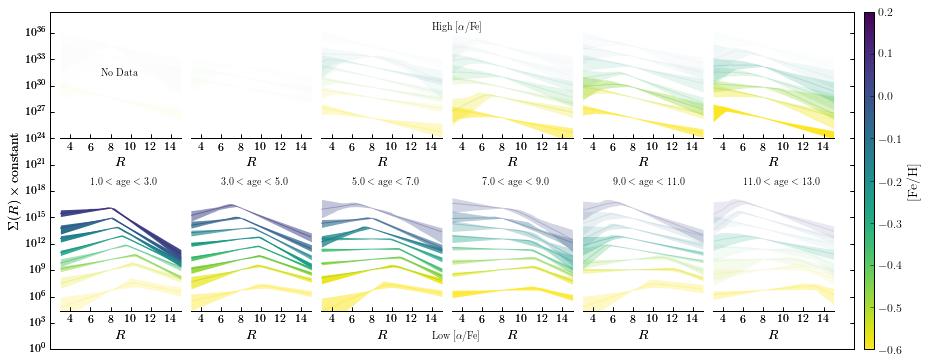

In [29]:
cmap = plt.cm.viridis_r
fig = plt.figure()
fig.set_size_inches(2*textwidth,0.7*textwidth)
mainax = AA.Axes(fig,[0.1,0.02,0.8,0.96])
fig.add_axes(mainax)
plt.yscale('log')
alpha_norm = 'row'
mainax.set_xticks([])
js = [0,1,2,3,4,5]
ages = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2]
y = [1,3,5,7,9,11,13]

for j in js:

    fltax = floating_axis(fig, [0.13*j+0.11,0.62,0.12,0.35])
    surfdens_plot(hsamples[:,j], np.concatenate((hmassgrid[:,j,0],lmassgrid[:,j,0])), hmassgrid[:,:,0], lmassgrid[:,:,0], fltax, numbins=np.array(hnumbins)[:,j], fage=False, alpha_norm=alpha_norm)
    fltax.set_xlim(3.,15.)
    fig.text(0.13*j+0.14,0.49, r'$'+str(round(y[j],1))+'< \mathrm{age} < '+str(round(y[j+1],1))+'$', fontsize=10)
for j in js:

    fltax = floating_axis(fig, [0.13*j+0.11,0.13,0.12,0.35])
    surfdens_plot(lsamples[:,j], np.concatenate((lmassgrid[:,j,0],hmassgrid[:,j,0])), hmassgrid[:,:,0], lmassgrid[:,:,0], fltax, numbins=np.array(lnumbins)[:,j], fage=False, alpha_norm=alpha_norm)
    fltax.set_xlim(3.,15.)
fig.text(0.48,0.05,r'$\mathrm{Low\ [\alpha/Fe]}$')
fig.text(0.48,0.93,r'$\mathrm{High\ [\alpha/Fe]}$')
limits = np.log10(fltax.get_ylim())
conversion = (0.96/0.3)*(np.fabs(limits[1])+np.fabs(limits[0]))
mainax.set_ylim(1e0,10**conversion)
cax = fig.add_axes([0.91,0.02,0.01,0.96])
norm = mpl.colors.Normalize(vmin=-0.6, vmax=0.2)
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m.set_array([])
plt.colorbar(s_m, cax=cax, label=r'$\mathrm{[Fe/H]}$')
mainax.set_ylabel(r'$\Sigma(R)\times\mathrm{constant}$')
fig.text(0.15,0.80, r'$\mathrm{No\ Data}$')

## Figure 7 - the radial $h_Z$ profiles

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.



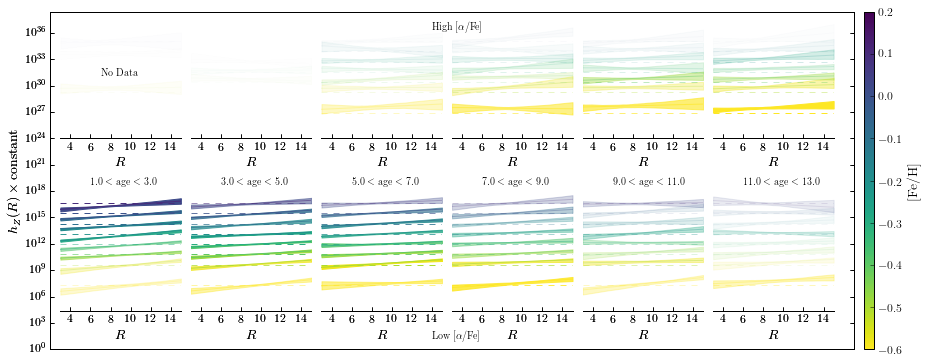

In [30]:
cmap = plt.cm.viridis_r
fig = plt.figure()
fig.set_size_inches(2*textwidth,0.7*textwidth)
mainax = AA.Axes(fig,[0.1,0.02,0.8,0.96])
fig.add_axes(mainax)
plt.yscale('log')

mainax.set_xticks([])
js = [0,1,2,3,4,5]
ages = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2]
y = [1,3,5,7,9,11,13]

for j in js:
    fig.text(0.13*j+0.14,0.49, r'$'+str(round(y[j],1))+'< \mathrm{age} < '+str(round(y[j+1],1))+'$', fontsize=10)
    fltax = floating_axis(fig, [0.13*j+0.11,0.62,0.12,0.35])
    hzprofile_plot(hsamples[:,j], np.concatenate((hmassgrid[:,j,0],lmassgrid[:,j,0])), hmassgrid[:,:,0], lmassgrid[:,:,0], fltax, numbins=np.array(hnumbins)[:,j], alpha_norm=alpha_norm, fage=False)
    fltax.set_xlim(3.,15.)
for j in js:
    fltax = floating_axis(fig, [0.13*j+0.11,0.13,0.12,0.35])
    hzprofile_plot(lsamples[:,j], np.concatenate((lmassgrid[:,j,0],hmassgrid[:,j,0])), hmassgrid[:,:,0], lmassgrid[:,:,0], fltax, numbins=np.array(lnumbins)[:,j], alpha_norm=alpha_norm, fage=False)
    fltax.set_xlim(3.,15.)
fig.text(0.48,0.05,r'$\mathrm{Low\ [\alpha/Fe]}$')
fig.text(0.48,0.93,r'$\mathrm{High\ [\alpha/Fe]}$')
limits = np.log10(fltax.get_ylim())
conversion = (0.96/0.3)*(np.fabs(limits[1])+np.fabs(limits[0]))
mainax.set_ylim(1e0,10**conversion)
cax = fig.add_axes([0.91,0.02,0.01,0.96])
norm = mpl.colors.Normalize(vmin=-0.6, vmax=0.2)
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m.set_array([])
fig.text(0.15,0.80, r'$\mathrm{No\ Data}$')
plt.colorbar(s_m, cax=cax, label=r'$\mathrm{[Fe/H]}$')
mainax.set_ylabel(r'$h_Z(R)\times\mathrm{constant}$')

## calculating the mean $h_Z$ and $R_{\mathrm{flare}}$ in each age bin

(0, 1.0)

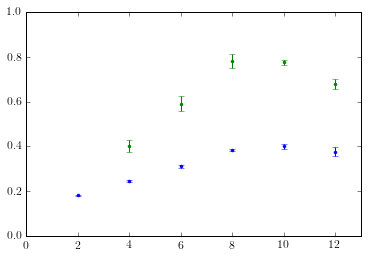

In [45]:
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

agebins = np.arange(1.,14.,2.)

agebincent = (np.array(agebins)[:-1]+np.array(agebins)[1:])/2.
fehbincent = (np.array(lfehbins)[:-1]+np.array(lfehbins)[1:])/2.
ntol=20

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)


bins = np.linspace(-0.8,0.5,400)
outs = []
for i in range(0,len(agebincent)):
    out = np.ones(len(bins))
    for j in range(0,len(fehbincent)):
        if np.array(lnumbins)[j,i] > ntol:
            l_rfs = lsamples[j,i,4]
            kde = gaussian_kde(l_rfs)
            #plt.plot(bins,kde(bins)/sum(kde(bins)), color='Black', alpha=0.3)
            out *= kde(bins)*lmassgrid[j,i,0]
    outs.append(out)

l_rfs = []
l_rferrs =  []
for i in outs:
    params, cov = curve_fit(gauss,bins,i/sum(i), [-0.1,0.05,0.12])
    l_rfs.append(params[0])
    l_rferrs.append(params[1])
            
bins = np.linspace(-0.8,0.5,400)
outs = []
for i in range(1,len(agebincent)):
    out = np.ones(len(bins))
    for j in range(0,len(fehbincent)):
        if np.array(hnumbins)[j,i] > ntol:
            h_rfs = hsamples[j,i,4]
            kde = gaussian_kde(h_rfs)
            #plt.plot(bins,kde(bins)/sum(kde(bins)), color='Black', alpha=0.3)
            out *= kde(bins)*hmassgrid[j,i,0]
    outs.append(out)

h_rfs = []
h_rferrs =  []
for i in outs:
    params, cov = curve_fit(gauss,bins,i/sum(i), [-0.05,0.05,0.12])
    h_rfs.append(params[0])
    h_rferrs.append(params[1])
    

bins = np.linspace(0.,3.,400)
outs = []
for i in range(0,len(agebincent)):
    out = np.ones(len(bins))
    for j in range(0,len(fehbincent)):
        if np.array(lnumbins)[j,i] > ntol:
            l_hzs = 1/lsamples[j,i,1]
            kde = gaussian_kde(l_hzs)
            #plt.plot(bins,kde(bins)/sum(kde(bins)), color='Black', alpha=0.3)
            out *= kde(bins)*lmassgrid[j,i,0]
    outs.append(out)

l_hzs = []
l_hzerrs =  []
for i in outs:
    if sum(i) == 0:
        l_hzs.append(np.nan)
        l_errs.append(np.nan)
        continue
    i_x = bins[np.where(i/sum(i) == np.max(i/sum(i)))][0]
    params, cov = curve_fit(gauss,bins,i/sum(i), [i_x,0.1,0.1])
    l_hzs.append(params[0])
    l_hzerrs.append(params[1])
            
bins = np.linspace(0,3.,400)
outs = []
for i in range(1,len(agebincent)):
    out = np.ones(len(bins))
    for j in range(0,len(fehbincent)):
        if np.array(hnumbins)[j,i] > ntol:
            h_hzs = 1/hsamples[j,i,1]
            kde = gaussian_kde(h_hzs)
            #plt.plot(bins,kde(bins)/sum(kde(bins)), color='Black', alpha=0.3)
            out *= kde(bins)*hmassgrid[j,i,0]
    outs.append(out)

h_hzs = []
h_hzerrs =  []
for i in outs:
    params, cov = curve_fit(gauss,bins,i/sum(i), [0.8,0.4,0.3])
    h_hzs.append(params[0])
    h_hzerrs.append(params[1])
    


## Figure 9 - Mean $h_Z$ and $R_{\mathrm{flare}}$ vs. Age (with surface mass density weighted mean)

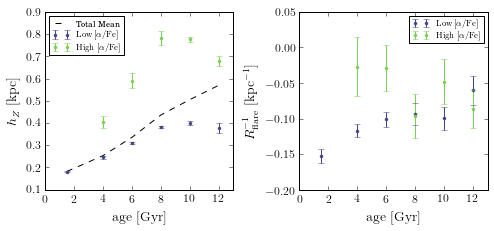

In [46]:
agebincent = (np.array(lagebins)[:-1]+np.array(lagebins)[1:])/2.
fehbincent = (np.array(lfehbins)[:-1]+np.array(lfehbins)[1:])/2.
cmap = plt.cm.coolwarm
lgrid = []
ldgrid = []
for j in range(0,len(fehbincent)):
    vals = []
    dvals = []
    for i in range(0,len(agebincent)):
        hRin = np.median(1/lsamples[j,i,0,::10])
        dhRin = np.std(1/lsamples[j,i,0,::10])
        hz = np.median(1/lsamples[j,i,1,::10])
        dhz = np.std(1/lsamples[j,i,1,::10])
        hRout = np.median(1/lsamples[j,i,2,::10])
        dhRout = np.std(1/lsamples[j,i,2,::10])
        rb = np.median(lsamples[j,i,3,::10])
        drb = np.std(lsamples[j,i,3,::10])
        rf = np.median(lsamples[j,i,4,::10])
        drf = np.std(lsamples[j,i,4,::10])
        mass = lmassgrid[j,i,0]
        m_samp = lm_samplegrid[j,i,:]
        m_samp = m_samp[np.isfinite(m_samp)]
        if lmassgrid[j,i,3] >= 0.:
            low = mass - lmassgrid[j,i,3]
        else:
            low = 0.
        hi = lmassgrid[j,i,4] - mass
        nsamples = 1000
        val = [hRin, hz, hRout, np.exp(rb), rf, mass]
        dval = [dhRin, dhz, dhRout, drb, drf, low, hi]
        vals.append(val)
        dvals.append(dval)
    lgrid.append(vals)
    ldgrid.append(dvals)
lgrid= np.array(lgrid)
ldgrid = np.array(ldgrid)

hgrid = []
hmgrid = []
hdgrid = []
for j in range(0,len(fehbincent)):
    vals = []
    dvals = []
    for i in range(0,len(agebincent)):
        hRin = np.median(1/hsamples[j,i,0,::10])
        dhRin = np.std(1/hsamples[j,i,0,::10])
        hz = np.median(1/hsamples[j,i,1,::10])
        dhz = np.std(1/hsamples[j,i,1,::10])
        hRout = np.median(1/hsamples[j,i,2,::10])
        dhRout = np.std(1/hsamples[j,i,2,::10])
        rb = np.median(hsamples[j,i,3,::10])
        drb = np.std(hsamples[j,i,3,::10])
        rf = np.median(hsamples[j,i,4,::10])
        drf = np.std(hsamples[j,i,4,::10])
        mass = hmassgrid[j,i,0]
        m_samp = hm_samplegrid[j,i,:]
        m_samp = m_samp[np.isfinite(m_samp)]
        low = mass - np.percentile(m_samp, 16)
        hi = np.percentile(m_samp, 84) - mass
        nsamples = 1000
        val = [hRin, hz, hRout, np.exp(rb), rf, mass]
        dval = [dhRin, dhz, dhRout, drb, drf, low, hi]
        vals.append(val)
        dvals.append(dval)
    hgrid.append(vals)
    hdgrid.append(dvals)
hgrid= np.array(hgrid)
hdgrid = np.array(hdgrid)

fig,ax = plt.subplots(1,2)
cmap= plt.cm.viridis
ages = (np.ones_like(lgrid[:,:,4])*((np.array(lagebins)[:-1]+np.array(lagebins)[1:])/2)).ravel()
jitters = np.random.uniform(low=-0.5,high=0.5, size=len(ages))
ages += jitters
lmask = np.array(lnumbins).ravel() > 30
hmask = np.array(hnumbins).ravel() > 30
lmed = movingmean(lgrid[:,:,1].ravel()[lmask],ages[lmask],lmassgrid[:,:,0].ravel()[lmask], lagebins)
hmed = movingmean(hgrid[:,:,1].ravel()[hmask],ages[hmask],hmassgrid[:,:,0].ravel()[hmask], hagebins)
comb_p = np.hstack((lgrid[:,:,1].ravel()[lmask],hgrid[:,:,1].ravel()[hmask]))
comb_age = np.hstack((ages[lmask], ages[hmask]))
comb_w = np.hstack((lmassgrid[:,:,0].ravel()[lmask],hmassgrid[:,:,0].ravel()[hmask]))
comb = movingmean(comb_p, comb_age, comb_w, hagebins)
ax[0].plot(agebincent,comb[:,0], color='Black', linestyle='dashed', label='Total Mean')
#plt.fill_between(agebincent, comb[:,0]-comb[:,1], comb[:,0]+comb[:,1], color='Gray', alpha=0.5, lw=0.)
ax[0].errorbar(agebincent,l_hzs, color=cmap(0.2), yerr=l_hzerrs, fmt='.', label=r'$\mathrm{Low\ [\alpha/Fe]}$')
ax[0].errorbar(agebincent[1:],h_hzs, color=cmap(0.8), yerr=h_hzerrs, fmt='.', label=r'$\mathrm{High\ [\alpha/Fe]}$')
#ax[0].fill_between(agebincent, lmed[:,0]-lmed[:,1], lmed[:,0]+lmed[:,1], color = cmap(0.2), alpha=0.5, lw=0.)
#ax[0].fill_between(agebincent, hmed[:,0]-hmed[:,1], hmed[:,0]+hmed[:,1], color = cmap(0.8), alpha=0.5, lw=0.)
#ax[0].plot(agebincent,lmed[:,0], color=cmap(0.2))
#ax[0].plot(agebincent,hmed[:,0], color=cmap(0.8))
ax[0].set_xlim(0.,13.)
ax[0].set_ylim(0.1,0.9)
ax[0].legend(loc=2, fontsize='small')

ax[0].set_ylabel(r'$h_Z\ \mathrm{[kpc]}$')
ax[0].set_xlabel(r'$\mathrm{age\ [Gyr]}$')

#ages = (np.ones_like(lgrid[:,:,4])*((lagebins[:-1]+lagebins[1:])/2)).ravel()
lmask = np.array(lnumbins).ravel() > 30
hmask = np.array(hnumbins).ravel() > 30
lmed = movingmean(lgrid[:,:,4].ravel()[lmask],ages[lmask],lmassgrid[:,:,0].ravel()[lmask], lagebins)
hmed = movingmean(hgrid[:,:,4].ravel()[hmask],ages[hmask],hmassgrid[:,:,0].ravel()[hmask], hagebins)
comb_p = np.hstack((lgrid[:,:,4].ravel()[lmask],hgrid[:,:,4].ravel()[hmask]))
comb_age = np.hstack((ages[lmask], ages[hmask]))
comb_w = np.hstack((lmassgrid[:,:,0].ravel()[lmask],hmassgrid[:,:,0].ravel()[hmask]))
comb = movingmean(comb_p, comb_age, comb_w, hagebins)
#ax[1].plot(agebincent,comb[:,0], color='Black', label='Weighted Mean')
#plt.fill_between(agebincent, comb[:,0]-comb[:,1], comb[:,0]+comb[:,1], color='Gray', alpha=0.5, lw=0.)
ax[1].errorbar(agebincent,l_rfs, color=cmap(0.2), yerr=l_rferrs, fmt='.', label=r'$\mathrm{Low\ [\alpha/Fe]}$')
ax[1].errorbar(agebincent[1:],h_rfs, color=cmap(0.8), yerr=h_rferrs, fmt='.', label=r'$\mathrm{High\ [\alpha/Fe]}$')
#ax[1].fill_between(agebincent, lmed[:,0]-lmed[:,1], lmed[:,0]+lmed[:,1], color = cmap(0.2), alpha=0.5, lw=0.)
#ax[1].fill_between(agebincent, hmed[:,0]-hmed[:,1], hmed[:,0]+hmed[:,1], color = cmap(0.8), alpha=0.5, lw=0.)
#ax[1].plot(agebincent,lmed[:,0], color=cmap(0.2))
#ax[1].plot(agebincent,hmed[:,0], color=cmap(0.8))
ax[1].set_xlim(0.,13.)
ax[1].set_ylim(-0.2,0.05)
ax[1].legend(loc=1, fontsize='small')

ax[1].set_ylabel(r'$R_{\mathrm{flare}}^{-1}\ \mathrm{[kpc^{-1}]}$')
ax[1].set_xlabel(r'$\mathrm{age\ [Gyr]}$')

l_hrin = lgrid[:,:,0].ravel()[lmask]
d_hrin = ldgrid[:,:,0].ravel()[lmask]
l_hrout = lgrid[:,:,2].ravel()[lmask]
d_hrout = ldgrid[:,:,2].ravel()[lmask]
agemask = ages < 13
delta = 1/(1/l_hrout[agemask]-1/l_hrin[agemask])
errs = np.sqrt(1/d_hrin[agemask]**2+1/d_hrout[agemask]**2)
errs = 1/errs
mm = movingmean(delta, ages[lmask][agemask], lmassgrid[:,:,0].ravel()[lmask][agemask], lagebins)
colors = np.zeros((len(delta),4))
'''
alphas = (lmassgrid[:,:,0].ravel()[lmask][hrmask]-np.min(lmassgrid[:,:,0].ravel()[lmask]))/(np.max(lmassgrid[:,:,0].ravel()[lmask])-np.min(lmassgrid[:,:,0].ravel()[lmask]))
alphas[alphas <= 0.] = 0.000001
alphas[alphas >= 1.] = 0.999999
colors[:,3] = alphas

ax[2].errorbar(ages[lmask][agemask], delta, yerr=errs, c='Black', fmt='.')
ax[2].plot(agebincent, mm[:,0], color='black', alpha=0.5)
ax[2].fill_between(agebincent, mm[:,0]-mm[:,1], mm[:,0]+mm[:,1], color='Gray', alpha=0.5, lw=0., )
ax[2].set_xlabel(r'$\mathrm{Age\ [Gyr]}$')
ax[2].set_ylabel(r'$(h_{R,\mathrm{out}}^{-1}-h_{R,\mathrm{in}}^{-1})^{-1}\ \mathrm{[Kpc]}$')
ax[2].legend(frameon=False)
ax[2].set_xlim(0.,13.)
ax[2].set_ylim(0.19,2.01)
ax[2].text(1,1.8,r'$\mathrm{Low\ [\alpha/Fe]\ only}$')
'''
fig.set_size_inches(1*textwidth, 1*columnwidth)
fig.tight_layout()

## Figure 8 - Profile Width vs age

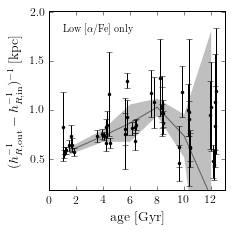

In [48]:
fig = plt.figure()
l_hrin = lgrid[:,:,0].ravel()[lmask]
d_hrin = ldgrid[:,:,0].ravel()[lmask]
l_hrout = lgrid[:,:,2].ravel()[lmask]
d_hrout = ldgrid[:,:,2].ravel()[lmask]
agemask = ages < 13
delta = 1/(1/l_hrout[agemask]-1/l_hrin[agemask])
errs = np.sqrt(1/d_hrin[agemask]**2+1/d_hrout[agemask]**2)
errs = 1/errs
mm = movingmean(delta, ages[lmask][agemask], lmassgrid[:,:,0].ravel()[lmask][agemask], lagebins)
'''
colors = np.zeros((len(delta),4))
alphas = (lmassgrid[:,:,0].ravel()[lmask][hrmask]-np.min(lmassgrid[:,:,0].ravel()[lmask]))/(np.max(lmassgrid[:,:,0].ravel()[lmask])-np.min(lmassgrid[:,:,0].ravel()[lmask]))
alphas[alphas <= 0.] = 0.000001
alphas[alphas >= 1.] = 0.999999
colors[:,3] = alphas
'''
plt.errorbar(ages[lmask][agemask], delta, yerr=errs, c='Black', fmt='.')
plt.plot(agebincent, mm[:,0], color='black', alpha=0.5)
plt.fill_between(agebincent, mm[:,0]-mm[:,1], mm[:,0]+mm[:,1], color='Gray', alpha=0.5, lw=0., )
plt.xlabel(r'$\mathrm{age\ [Gyr]}$')
plt.ylabel(r'$(h_{R,\mathrm{out}}^{-1}-h_{R,\mathrm{in}}^{-1})^{-1}\ \mathrm{[kpc]}$')
plt.legend(frameon=False)
plt.xlim(0.,13.)
plt.ylim(0.19,2.01)
plt.text(1,1.8,r'$\mathrm{Low\ [\alpha/Fe]\ only}$')
fig.set_size_inches(1*columnwidth, columnwidth)
fig.tight_layout()

## Figure 10 - mass weighted age-$\mathrm{[Fe/H]}$ distribution as a function of $\mathrm{[\alpha/Fe]}$

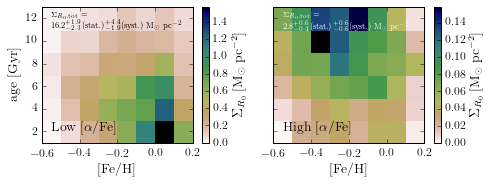

In [50]:
ntol=30
fig,ax = plt.subplots(1,2, sharex=True, sharey=True)

mgrids = lgrid[:,:,5].ravel()
#mgrids = np.array(numbins).ravel()
lmask = np.where(np.array(lnumbins).ravel() > 15) 
ltot =  np.nansum(mgrids[lmask])#/(2*np.pi)
llow = np.nansum(ldgrid[:,:,5].ravel()[lmask])
lhi = np.nansum(ldgrid[:,:,6].ravel()[lmask])
norm = mpl.colors.Normalize(vmin=0., vmax=max(mgrids[lmask]))
norm2 = mpl.colors.Normalize(vmin=0., vmax=max(hgrid[:,:,5].ravel()))
c_m = mpl.cm.gist_earth_r
s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m2 = mpl.cm.ScalarMappable(cmap=c_m, norm=norm2)
s_m.set_array([])
s_m2.set_array([])

for j in range(0, len(lfehbins)-1):
    for i in range(0,len(lagebins)-1):
        tmass = lmassgrid[j,i,0]#/(2*np.pi)
        #tmass = np.array(numbins)[j,i]
        xedges = [lfehbins[j], lfehbins[j+1]]
        yedgelow = [lagebins[i], lagebins[i]]
        yedgehigh = [lagebins[i+1], lagebins[i+1]]
        if np.array(lnumbins)[j,i] > ntol:
            ax[0].fill_between(xedges, yedgelow,yedgehigh, color=s_m.to_rgba(tmass))
            
ax[0].set_xlim(-0.6,0.2)
ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[0].set_ylabel(r'$\mathrm{age\ [Gyr]}$')
#plt.colorbar(s_m, label=r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{2}]}$')
fig.set_size_inches(5,5)
fig.subplots_adjust(wspace=0.2)
plt.ylim(1.,13.)

mgrids = hgrid[:,:,5].ravel()
#mgrids = np.array(numbins).ravel()
hmask = np.where(np.array(hnumbins).ravel() > 15) 
htot = np.nansum(mgrids[hmask])#/(2*np.pi)
hlow = np.nansum(hdgrid[:,:,5].ravel()[hmask])
hhi = np.nansum(hdgrid[:,:,6].ravel()[hmask])

for j in range(0, len(hfehbins)-1):
    for i in range(0,len(hagebins)-1):
        tmass = hmassgrid[j,i,0]#/(2*np.pi)
        #tmass = np.array(numbins)[j,i]
        xedges = [hfehbins[j], hfehbins[j+1]]
        yedgelow = [hagebins[i], hagebins[i]]
        yedgehigh = [hagebins[i+1], hagebins[i+1]]
        ax[1].fill_between(xedges, yedgelow,yedgehigh, color=s_m2.to_rgba(tmass))
            
ax[1].set_xlim(-0.6,0.2)
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
#ax[1].set_ylabel(r'Age $\mathrm{[Gyr]}$')

fulltot = ltot+htot
fulllow = llow+hlow
fullhi = lhi+hhi
'''
for j in range(0, len(hfehbins)-1):
    for i in range(0,len(hagebins)-1):
        tmass = hmassgrid[j,i,0]+lmassgrid[j,i,0]#/(2*np.pi)
        #tmass = np.array(numbins)[j,i]
        xedges = [hfehbins[j], hfehbins[j+1]]
        yedgelow = [hagebins[i], hagebins[i]]
        yedgehigh = [hagebins[i+1], hagebins[i+1]]
        ax[2].fill_between(xedges, yedgelow,yedgehigh, color=s_m.to_rgba(tmass))
            
ax[2].set_xlim(-0.6,0.2)
ax[2].set_xlabel(r'$\mathrm{[Fe/H]}$')
#ax[2].set_ylabel(r'Age $\mathrm{[Gyr]}$')

'''
#fig.subplots_adjust(wspace=0.2)
#fig.subplots_adjust(wspace=0.2, right=0.8, bottom=0.15)
ax[0].set_ylim(1.,13.)
#cax = fig.add_axes([0.87,0.21,0.02,0.72])
#plt.colorbar(s_m, ax=ax[2], label=r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')
plt.colorbar(s_m, ax=ax[0], label=r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')
plt.colorbar(s_m2, ax=ax[1], label=r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')

cplt = 'Black'
ax[0].text(-0.55,2,r'$\mathrm{Low\ [\alpha/Fe]}$', fontsize=14, color=cplt)
ax[0].text(-0.55,12,r'$\Sigma_{R_0,\mathrm{tot}} =$', fontsize=8)
ax[0].text(-0.55,11,r'$'+str(round(ltot,1))+'^{+'+str(round(lhi,1))+'}_{-'+str(round(llow,1))+'}\mathrm{(stat.)}_{-1.9}^{+4.4}\mathrm{(syst.)}\ \mathrm{M_{\odot}\ pc^{-2}}$',fontsize=8, color=cplt)
ax[1].text(-0.55,12,r'$\Sigma_{R_0,\mathrm{tot}} =$', fontsize=8, color='White')
ax[1].text(-0.55,11,r'$'+str(round(htot,1))+'^{+'+str(round(hhi,1))+'}_{-'+str(round(hlow,1))+'}\mathrm{(stat.)}_{-0.6}^{+0.6}\mathrm{(syst.)}\ \mathrm{M_{\odot}\ pc^{-2}}$',fontsize=8, color='White')
#ax[2].text(-0.55,12,r'$\Sigma_{R_0,tot} ='+str(round(fulltot,1))+'^{+'+str(round(fullhi,1))+'}_{-'+str(round(fulllow,1))+'}\ \mathrm{M_{\odot}\ pc^{-2}}$',fontsize=10, color=cplt)

ax[1].text(-0.55,2.,r'$\mathrm{High\ [\alpha/Fe]}$', fontsize=14, color=cplt)
#ax[2].text(-0.55,2.,r'$\mathrm{total}$', fontsize=14, color=cplt)

ax[0].set_xticks([-0.6,-0.4,-0.2,0.,0.2])
ax[1].set_xticks([-0.6,-0.4,-0.2,0.,0.2])
fig.set_size_inches(1*textwidth,0.8*columnwidth)
fig.tight_layout()
#fig.subplots_adjust(right=0.86, wspace=0.05)

## Figure 11 - total mass weighted age-$\mathrm{[Fe/H]}$ distribution

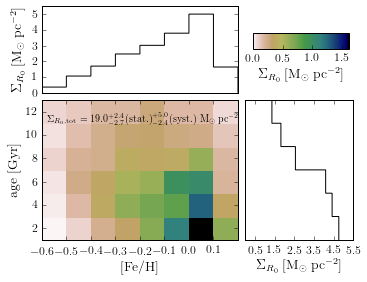

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
ax = plt.subplot()

mgrids = lgrid[:,:,5].ravel()+hgrid[:,:,5].ravel()
#mgrids = np.array(numbins).ravel()
lmask = np.where(np.array(lnumbins).ravel() > 15) 
ltot =  np.nansum(mgrids[lmask])#/(2*np.pi)
llow = np.nansum(ldgrid[:,:,5].ravel()[lmask])
lhi = np.nansum(ldgrid[:,:,6].ravel()[lmask])
norm = mpl.colors.Normalize(vmin=0., vmax=max(mgrids[lmask]))
c_m = mpl.cm.gist_earth_r
s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


for j in range(0, len(hfehbins)-1):
    for i in range(0,len(hagebins)-1):
        tmass = hmassgrid[j,i,0]+lmassgrid[j,i,0]#/(2*np.pi)
        #tmass = np.array(numbins)[j,i]
        xedges = [hfehbins[j], hfehbins[j+1]]
        yedgelow = [hagebins[i], hagebins[i]]
        yedgehigh = [hagebins[i+1], hagebins[i+1]]
        ax.fill_between(xedges, yedgelow,yedgehigh, color=s_m.to_rgba(tmass))
divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top", size=1.2, pad=0.1)
axHisty = divider.append_axes("right", size=1.5, pad=0.1)
fehs = (np.ones_like(hmassgrid[:,:,0]).T*fehbincent).T
ages = (np.ones_like(hmassgrid[:,:,0])*agebincent)
axHistx.hist(fehs.ravel(), bins = lfehbins, weights = (hmassgrid[:,:,0]+lmassgrid[:,:,0]).ravel(), histtype='step', color='Black')
axHisty.hist(ages.ravel(), bins = lagebins, weights = (hmassgrid[:,:,0]+lmassgrid[:,:,0]).ravel(), histtype='step', color='Black', orientation='horizontal')
ax.set_xlim(-0.6,0.2)
ax.set_ylim(1,13.)
ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
ax.set_ylabel(r'$\mathrm{age\ [Gyr]}$')
ax.set_xticks(np.arange(-0.6,0.2,0.1))
axHisty.set_yticks([])
axHistx.set_xticks([])
axHistx.set_ylim(0.,5.5)
axHisty.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])
axHisty.set_ylim(1.,13.)
axHistx.set_ylabel(r'$\Sigma_{R_0}\ \mathrm{[M_{\odot}\ pc^{-2}]}$')
axHisty.set_xlabel(r'$\Sigma_{R_0}\ \mathrm{[M_{\odot}\ pc^{-2}]}$')
cax = fig.add_axes([0.65,0.76,0.24,0.05])
cb = plt.colorbar(s_m, cax=cax, orientation='horizontal', label=r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')
cb.set_ticks([0.,0.5,1.,1.5])
ax.text(-0.58,11,r'$\Sigma_{R_0,\mathrm{tot}} ='+str(round(fulltot,1))+'^{+'+str(round(fullhi,1))+'}_{-'+str(round(fulllow,1))+'}\mathrm{(stat.)}_{-2.4}^{+5.0}\mathrm{(syst.)}\ \mathrm{M_{\odot}\ pc^{-2}}$',fontsize=10, color=cplt)
fig.set_size_inches(0.8*textwidth,0.6*textwidth)

## Figure 12 - $h_Z$ PDF

(2, 48)
(48,)
(48,)
//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2748: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)



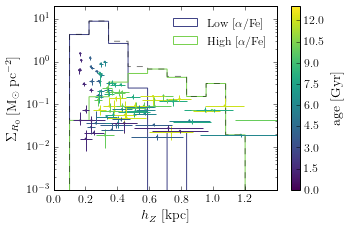

In [53]:

lmask = (np.array(lnumbins).ravel() > 30)
hmask = (np.array(hnumbins).ravel() > 30) #& (hmassgrid.ravel() < 5.)

l_hz = lgrid[:,:,1].ravel()[lmask]
l_dhz = ldgrid[:,:,1].ravel()[lmask]
h_hz = hgrid[:,:,1].ravel()[hmask]
h_dhz = hdgrid[:,:,1].ravel()[hmask]

l_mass = lgrid[:,:,5].ravel()[lmask]
l_low = ldgrid[:,:,5].ravel()[lmask]
l_hi = ldgrid[:,:,6].ravel()[lmask]
l_merr = np.dstack((l_low,l_hi))[0].T
print np.shape(l_merr)
h_mass = hgrid[:,:,5].ravel()[hmask]
h_low = hdgrid[:,:,5].ravel()[hmask]
h_hi = hdgrid[:,:,6].ravel()[hmask]
h_merr = np.dstack((h_low,h_hi))[0].T

ages = (np.ones_like(lgrid[:,:,1])*((np.array(lagebins)[:-1]+np.array(lagebins)[1:])/2)).ravel()

norm = mpl.colors.Normalize(vmin=0, vmax=13.)
c_m = mpl.cm.viridis
s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


print np.shape(ages)
print np.shape(l_hz)
fig = plt.figure()
plt.errorbar(l_hz, l_mass, xerr=l_dhz, yerr=l_merr, fmt=None, linewidth=1, ecolor=s_m.to_rgba(ages[lmask]), capsize=0.)
plt.scatter(l_hz, l_mass, c=s_m.to_rgba(ages[lmask]), lw=0., s=5)
plt.errorbar(h_hz, h_mass, xerr=h_dhz, yerr=h_merr, fmt=None, ecolor=s_m.to_rgba(ages[hmask]), linewidth=1, capsize=0.)
plt.scatter(h_hz, h_mass, c=s_m.to_rgba(ages[hmask]), lw=0., s=5)

bins = np.linspace(0.1,1.2,10)
llabel = r'$\mathrm{Low\ [\alpha/Fe]}$'
hlabel = r'$\mathrm{High\ [\alpha/Fe]}$'
plt.hist(l_hz, weights=l_mass, bins=bins, color=cmap(0.2), histtype='step', label=llabel)
plt.hist(h_hz[np.isfinite(h_mass)], bins=bins,weights=h_mass[np.isfinite(h_mass)],color=cmap(0.8), histtype='step', label=hlabel)
stack_hz = np.hstack((l_hz,h_hz))
stack_mass = np.hstack((l_mass,h_mass))
plt.hist(stack_hz[np.isfinite(stack_mass)], bins=bins,weights=stack_mass[np.isfinite(stack_mass)],color='black', histtype='step', linestyle='dashed', alpha=0.5)
plt.yscale('log')
plt.ylim(1e-3,2e1)
plt.xlim(0.,1.4)
plt.ylabel(r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')
plt.xlabel(r'$h_Z$ $\mathrm{[kpc]}$')
plt.legend(frameon=False)
plt.colorbar(s_m, label=r'$\mathrm{age\ [Gyr]}$')
fig.set_size_inches(1.5*columnwidth,columnwidth)
fig.tight_layout()

## Figure 13 - The surface-mass density profiles (combined in age and $\mathrm{[[Fe/H]}$)

[array([ 2.31742506,  2.31350387,  2.30360986, ...,  0.01678818,
        0.01666929,  0.01654698]), array([ 3.82336082,  3.82025738,  3.80901098, ...,  0.04055562,
        0.04034724,  0.04013996]), array([ 6.74744889,  6.71634319,  6.68837638, ...,  0.03614975,
        0.03595946,  0.03577042]), array([ 4.05531929,  4.04679353,  4.03725975, ...,  0.01977229,
        0.01964316,  0.01951488]), array([ 4.51883255,  4.51058498,  4.50834867, ...,  0.01632542,
        0.01621704,  0.0161094 ]), array([ 3.80247688,  3.79520641,  3.78814137, ...,  0.00747364,
        0.00741234,  0.00735155])]
[ 2.71076265  2.72010872  2.72950914 ...,  0.14124237  0.13987625
  0.13852522]


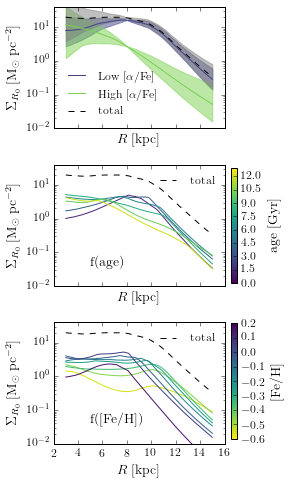

In [55]:
def ret_map_surfdens(samp, j, i, inv_ihRin=True, _SIGNIF=0.025):
    tsamp= samp[j,i,:,::_SKIP]
    nsamples= len(tsamp[0])
    tRs= numpy.tile(Rs,(nsamples,1)).T
    ldp= numpy.empty((len(Rs),nsamples))
    Rb= numpy.tile(numpy.exp(tsamp[3]),(len(Rs),1))
    ihRin= numpy.tile(tsamp[0],(len(Rs),1))
    if inv_ihRin == True:
        ihRin = -numpy.tile(tsamp[0],(len(Rs),1))
    ihRout= numpy.tile(tsamp[2],(len(Rs),1))
    # Rb >= R0
    leRb= (tRs <= Rb)*(Rb >= densprofiles._R0)
    ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)
    gtRb= (tRs > Rb)*(Rb >= densprofiles._R0)
    ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)\
        +ihRout[gtRb]*(Rb[gtRb]-densprofiles._R0)\
        +ihRin[gtRb]*(Rb[gtRb]-densprofiles._R0)
    # Rb < R0, normalize outer at R0
    leRb= (tRs <= Rb)*(Rb < densprofiles._R0)
    ldp[leRb]= ihRin[leRb]*(tRs[leRb]-densprofiles._R0)\
        -ihRout[leRb]*(Rb[leRb]-densprofiles._R0)\
        -ihRin[leRb]*(Rb[leRb]-densprofiles._R0)
    gtRb= (tRs > Rb)*(Rb < densprofiles._R0)
    ldp[gtRb]= -ihRout[gtRb]*(tRs[gtRb]-densprofiles._R0)
    # Label and relative normalization
    norm= numpy.exp(numpy.median(ldp,axis=1))[numpy.argmin(numpy.fabs(Rs-densprofiles._R0))]
    return Rs,numpy.exp(numpy.median(ldp,axis=1))/norm,numpy.exp(numpy.sort(ldp,axis=1)[:,int(round(_SIGNIF*nsamples))])/norm,numpy.exp(numpy.sort(ldp,axis=1)[:,int(round((1.-_SIGNIF)*nsamples))])/norm
        
    
_SKIP = 10
_SIGNIF = 0.025
Rs= numpy.linspace(3.,15.,1001)

lnumbins = np.array(lnumbins)
hnumbins = np.array(hnumbins)
ntol = 30.
densprofs = []
densprofs_lo = []
densprofs_hi = []
totalmass = []
for ii,age in enumerate(agebincent):
    tdensprofs = []
    tdensprofs_lo = []
    tdensprofs_hi = []
    totmass = 0
    for jj,feh in enumerate(fehbincent):
        mass = lgrid[jj,ii,5]
        if lnumbins[jj,ii] < ntol:
            mass = 0.
        rs, ldp, ldp_lo, ldp_hi = ret_map_surfdens(lsamples, jj,ii, inv_ihRin=True)
        ldp *= mass#/(2*np.pi)
        ldp_lo *= mass
        ldp_hi *= mass
        totmass += mass#/(2*np.pi)
        tdensprofs.append(ldp)
        tdensprofs_lo.append(ldp_lo)
        tdensprofs_hi.append(ldp_hi)
    tdensprofs = np.array(tdensprofs)
    tdensprofs_lo = np.array(tdensprofs_lo)
    tdensprofs_hi = np.array(tdensprofs_hi)
    if totmass != 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)/totmass
        totaldensprof_lo = np.nansum(tdensprofs_lo, axis=0)/totmass
        totaldensprof_hi = np.nansum(tdensprofs_hi, axis=0)/totmass
        densprofs.append(totaldensprof)
        densprofs_lo.append(totaldensprof_lo)
        densprofs_hi.append(totaldensprof_hi)
        totalmass.append(totmass)
    if totmass == 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)*0.
        totaldensprof_lo = np.nansum(tdensprofs_lo, axis=0)*0.
        totaldensprof_hi = np.nansum(tdensprofs_hi, axis=0)*0.
        densprofs.append(totaldensprof)
        densprofs_lo.append(totaldensprof_lo)
        densprofs_hi.append(totaldensprof_hi)
        totalmass.append(totmass) 
    
ldensprofs = np.array(densprofs)
ldensprofs_lo = np.array(densprofs_lo)
ldensprofs_hi = np.array(densprofs_hi)
ltotalmass = np.array(totalmass)

densprofs = []
densprofs_lo = []
densprofs_hi = []
totalmass = []
for ii,age in enumerate(agebincent):
    tdensprofs = []
    tdensprofs_lo = []
    tdensprofs_hi = []
    totmass = 0
    for jj,feh in enumerate(fehbincent):
        mass = hgrid[jj,ii,5]
        if hnumbins[jj,ii] < ntol:
            mass = 0.
        rs, ldp, ldp_lo, ldp_hi = ret_map_surfdens(hsamples, jj,ii, inv_ihRin=True)
        ldp *= mass#/(2*np.pi)
        ldp_lo *= mass
        ldp_hi *= mass
        totmass += mass#/(2*np.pi)
        tdensprofs.append(ldp)
        tdensprofs_lo.append(ldp_lo)
        tdensprofs_hi.append(ldp_hi)
    tdensprofs = np.array(tdensprofs)
    tdensprofs_lo = np.array(tdensprofs_lo)
    tdensprofs_hi = np.array(tdensprofs_hi)
    if totmass != 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)/totmass
        totaldensprof_lo = np.nansum(tdensprofs_lo, axis=0)/totmass
        totaldensprof_hi = np.nansum(tdensprofs_hi, axis=0)/totmass
        densprofs.append(totaldensprof)
        densprofs_lo.append(totaldensprof_lo)
        densprofs_hi.append(totaldensprof_hi)
        totalmass.append(totmass)
    if totmass == 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)*0.
        totaldensprof_lo = np.nansum(tdensprofs_lo, axis=0)*0.
        totaldensprof_hi = np.nansum(tdensprofs_hi, axis=0)*0.
        densprofs.append(totaldensprof)
        densprofs_lo.append(totaldensprof_lo)
        densprofs_hi.append(totaldensprof_hi)
        totalmass.append(totmass) 
print densprofs
hdensprofs = np.array(densprofs)
hdensprofs_lo = np.array(densprofs_lo)
hdensprofs_hi = np.array(densprofs_hi)
htotalmass = np.array(totalmass)

norm = mpl.colors.Normalize(vmin=0., vmax=13.)
cmap = plt.cm.viridis
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m.set_array([])

columnwidth = 240./72.27
textwidth = 504.0/72.27

fig, ax = plt.subplots(3,1,sharex=True, sharey=True)
ax[0].plot(rs,np.sum(ldensprofs.T*ltotalmass, axis=1), color=cmap(0.2), label=llabel)
ax[0].fill_between(rs, np.sum(ldensprofs_lo.T*(ltotalmass), axis=1), np.sum(ldensprofs_hi.T*(ltotalmass), axis=1), color=cmap(0.2), alpha=0.5)
ax[0].plot(rs,np.sum(hdensprofs.T*htotalmass, axis=1), color=cmap(0.8), label=hlabel)
ax[0].fill_between(rs, np.sum(hdensprofs_lo.T*(htotalmass), axis=1), np.sum(hdensprofs_hi.T*(htotalmass), axis=1), color=cmap(0.8), alpha=0.5)
alldensprofs = np.hstack((ldensprofs.T,hdensprofs.T))
alldensprofs_lo = np.hstack((ldensprofs_lo.T, hdensprofs_lo.T))
alldensprofs_hi = np.hstack((ldensprofs_hi.T, hdensprofs_hi.T))
alltotmass = np.hstack((ltotalmass,htotalmass))
ax[0].plot(rs,np.sum(alldensprofs*alltotmass, axis=1), color='black', linestyle='dashed', label='$\mathrm{total}$')
ax[0].fill_between(rs, np.sum(alldensprofs_lo*(alltotmass), axis=1), np.sum(alldensprofs_hi*(alltotmass), axis=1), color='Gray', alpha=0.5)
ax[0].set_yscale('log')
ax[0].legend(loc=3, frameon=False)
ax[0].set_xlabel(r'$R\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')
print np.sum(ldensprofs_lo.T*ltotalmass, axis=1)
alldens = []
allmass = []
for ii,prof in enumerate(densprofs):
    tdensprof = np.stack((ldensprofs[ii],hdensprofs[ii]))
    ttotalmass = np.hstack((ltotalmass[ii], htotalmass[ii]))
    ax[1].plot(rs,np.sum(tdensprof.T*ttotalmass, axis=1), color = s_m.to_rgba(agebincent[ii]))
    alldens.extend(tdensprof)
    allmass.extend(ttotalmass)
alldens = np.array(alldens)
allmass = np.array(allmass)
ax[1].plot(rs,np.sum(alldens.T*allmass, axis=1), color='black', linestyle='dashed', label='$\mathrm{total}$')


ax[1].legend(loc=1, frameon=False)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-2,1.1e1)
ax[1].set_xlabel(r'$R\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')

densprofs = []
totalmass = []
for jj,feh in enumerate(fehbincent):
    tdensprofs = []
    totmass = 0
    for ii,age in enumerate(agebincent):
        mass = lmassgrid[jj,ii,0]
        if lnumbins[jj,ii] < ntol:
            mass = 0.
        rs, ldp, ldp_lo, ldp_hi = ret_map_surfdens(lsamples, jj,ii, inv_ihRin=True)
        ldp *= mass#/(2*np.pi)
        totmass += mass#/(2*np.pi)
        tdensprofs.append(ldp)
    tdensprofs = np.array(tdensprofs)
    if totmass != 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)/totmass
        densprofs.append(totaldensprof)
        totalmass.append(totmass)
    if totmass == 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)*0.
        densprofs.append(totaldensprof)
        totalmass.append(totmass) 
    
ldensprofs = np.array(densprofs)
ltotalmass = np.array(totalmass)

densprofs = []
totalmass = []
for jj,feh in enumerate(fehbincent):
    tdensprofs = []
    totmass = 0
    for ii,age in enumerate(agebincent):
        mass = hmassgrid[jj,ii,0]
        if hnumbins[jj,ii] < ntol:
            mass = 0.
        rs, ldp, ldp_lo, ldp_hi = ret_map_surfdens(hsamples, jj,ii, inv_ihRin=True)
        ldp *= mass#/(2*np.pi)
        totmass += mass#/(2*np.pi)
        tdensprofs.append(ldp)
    tdensprofs = np.array(tdensprofs)
    if totmass != 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)/totmass
        densprofs.append(totaldensprof)
        totalmass.append(totmass)
    if totmass == 0:
        totaldensprof = np.nansum(tdensprofs, axis=0)*0.
        densprofs.append(totaldensprof)
        totalmass.append(totmass) 
    
hdensprofs = np.array(densprofs)
htotalmass = np.array(totalmass)

cax = fig.add_axes([0.77,0.42,0.02,0.23])
plt.colorbar(s_m, cax=cax,label=r'$\mathrm{age}\ \mathrm{[Gyr]}$',)

norm = mpl.colors.Normalize(vmin=-0.6, vmax=0.2)
cmap = plt.cm.viridis_r
s_m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
s_m.set_array([])


alldens = []
allmass = []
for ii,prof in enumerate(densprofs):
    tdensprof = np.stack((ldensprofs[ii],hdensprofs[ii]))
    ttotalmass = np.hstack((ltotalmass[ii], htotalmass[ii]))
    ax[2].plot(rs,np.sum(tdensprof.T*ttotalmass, axis=1), color = s_m.to_rgba(fehbincent[ii]))
    alldens.extend(tdensprof)
    allmass.extend(ttotalmass)
alldens = np.array(alldens)
allmass = np.array(allmass)
ax[2].plot(rs,np.sum(alldens.T*allmass, axis=1), color='black', linestyle='dashed', label=r'$\mathrm{total}$')


ax[2].legend(loc=1, frameon=False)
ax[2].set_yscale('log')
ax[2].set_ylim(1e-2,4e1)
ax[2].set_xlabel(r'$R\ \mathrm{[kpc]}$')
ax[2].set_ylabel(r'$\Sigma_{R_0}$ $\mathrm{[M_{\odot}\ pc^{-2}]}$')

fig.set_size_inches(1.3*columnwidth,1*textwidth)
fig.subplots_adjust(left=0.2,bottom=0.1,right=0.75,top=0.97, hspace=0.3)
cax = fig.add_axes([0.77,0.11,0.02,0.23])
plt.colorbar(s_m, cax=cax,label=r'$\rm{[Fe/H]}$')

ax[1].text(5,4e-2, r'$\rm{f(age)}$', fontsize=14)
ax[2].text(5,4e-2, r'$\rm{f([Fe/H])}$', fontsize=14)

## Figure 14 - MDF's at different radii

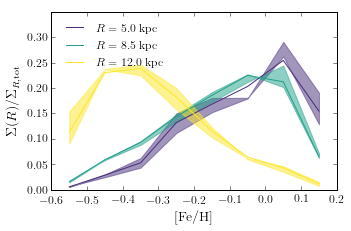

In [59]:
def surfdensatR(R, samp, mass):
    rs, prof, proflo, profhi = return_profile(samp,inv_ihRin=True)
    prof = prof*mass
    proflo = proflo*mass
    profhi = profhi*mass
    return prof[numpy.argmin(numpy.fabs(rs-R))], proflo[numpy.argmin(numpy.fabs(rs-R))], profhi[numpy.argmin(numpy.fabs(rs-R))]

radii = [5.,8.5,12.]
massR = []
massRlo = []
massRhi =[]
for R in radii:
    masses = []
    masseslo = []
    masseshi = []
    for i in range(0, len(fehbincent)):
        fehmass = 0.
        fehmasslo = 0.
        fehmasshi = 0.
        for j in range(0,len(agebincent)):
            m, mlo, mhigh = surfdensatR(R, lsamples[i,j,:], lmassgrid[i,j,0])
            #mlo = surfdensatR(R, lsamples[i,j,:], lmassgrid[i,j,3])
            #mhigh = surfdensatR(R, lsamples[i,j,:], lmassgrid[i,j,4])
            #m += surfdensatR(R, hsamples[i,j,:], hmassgrid[i,j,0])
            fehmass += m
            fehmasslo += mlo
            fehmasshi += mhigh
        masses.append(fehmass)
        masseslo.append(fehmasslo)
        masseshi.append(fehmasshi)
    massR.append(masses/np.sum(masses))
    massRlo.append(masseslo/np.sum(masseslo))
    massRhi.append(masseshi/np.sum(masseshi))
    
fig = plt.figure()
for i in range(0,len(radii)):
    plt.plot(fehbincent,np.array(massR)[i], c = plt.cm.viridis((radii[i]-4)/8.), label=r'$R = '+str(radii[i])+'\ \mathrm{kpc}$')
    plt.fill_between(fehbincent, np.array(massRlo)[i], np.array(massRhi)[i], color = plt.cm.viridis((radii[i]-4)/8.), alpha=0.5)
plt.ylim(0.,0.35)
plt.legend(frameon=False, loc=2)
plt.ylabel(r'$\Sigma(R)/\Sigma_{R,\mathrm{tot}}$')
plt.xlabel(r'$\mathrm{[Fe/H]}$')
fig.set_size_inches(1.5*columnwidth, columnwidth)
fig.tight_layout()

## Figure 14 - $R_{\mathrm{peak}}$ as a function of age and $\mathrm{[Fe/H]}$

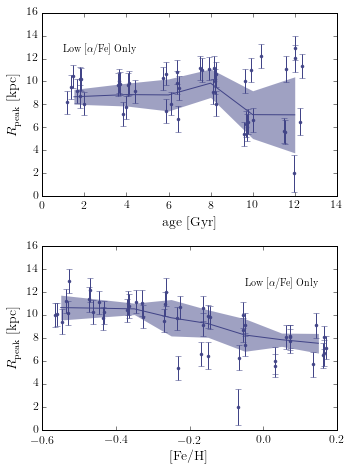

In [61]:
fig,ax = plt.subplots(2,1)
cmap= plt.cm.viridis
ages = (np.ones_like(lgrid[:,:,4])*((np.array(lagebins)[:-1]+np.array(lagebins)[1:])/2)).ravel()
fehs = (np.ones_like(lgrid[:,:,4]).T*((np.array(lfehbins)[:-1]+np.array(lfehbins)[1:])/2)).T.ravel()
agejitters = np.random.uniform(low=-0.5,high=0.5, size=len(ages))
fehjitters = np.random.uniform(low=-0.025, high=0.025, size=len(fehs))
ages += agejitters
fehs += fehjitters
lmask = np.array(lnumbins).ravel() > 30
hmask = np.array(hnumbins).ravel() > 30
lmed = movingmean(lgrid[:,:,3].ravel()[lmask],ages[lmask],lmassgrid[:,:,0].ravel()[lmask], lagebins)
hmed = movingmean(hgrid[:,:,3].ravel()[hmask],ages[hmask],hmassgrid[:,:,0].ravel()[hmask], hagebins)
comb_p = np.hstack((lgrid[:,:,3].ravel()[lmask],hgrid[:,:,3].ravel()[hmask]))
comb_age = np.hstack((ages[lmask], ages[hmask]))
comb_w = np.hstack((lmassgrid[:,:,0].ravel()[lmask],hmassgrid[:,:,0].ravel()[hmask]))
comb = movingmean(comb_p, comb_age, comb_w, hagebins)
#ax[0].plot(agebincent,comb[:,0], color='Black', linestyle='dashed', label='Total Mean')
#plt.fill_between(agebincent, comb[:,0]-comb[:,1], comb[:,0]+comb[:,1], color='Gray', alpha=0.5, lw=0.)
ax[0].errorbar(ages[lmask],lgrid[:,:,3].ravel()[lmask], color=cmap(0.2), yerr=np.exp(ldgrid[:,:,3].ravel()[lmask]), fmt='.', label=r'$\mathrm{Low\ [\alpha/Fe]}$')
#ax[0].errorbar(ages[hmask],hgrid[:,:,3].ravel()[hmask], color=cmap(0.8),yerr=np.exp(hdgrid[:,:,3].ravel()[hmask]), fmt='.', label=r'$\mathrm{High\ [\alpha/Fe]}$')
ax[0].fill_between(agebincent, lmed[:,0]-lmed[:,1], lmed[:,0]+lmed[:,1], color = cmap(0.2), alpha=0.5, lw=0.)
#ax[0].fill_between(agebincent, hmed[:,0]-hmed[:,1], hmed[:,0]+hmed[:,1], color = cmap(0.8), alpha=0.5, lw=0.)
ax[0].plot(agebincent,lmed[:,0], color=cmap(0.2))
#ax[0].plot(agebincent,hmed[:,0], color=cmap(0.8))

#ax[0].legend(loc=2, fontsize='small')

ax[0].set_ylabel(r'$R_{\mathrm{peak}}\ \mathrm{[kpc]}$')
ax[0].set_xlabel(r'$\mathrm{age\ [Gyr]}$')

lmed = movingmean(lgrid[:,:,3].ravel()[lmask],fehs[lmask],lmassgrid[:,:,0].ravel()[lmask], lfehbins)
hmed = movingmean(hgrid[:,:,3].ravel()[hmask],fehs[hmask],hmassgrid[:,:,0].ravel()[hmask], hfehbins)
comb_p = np.hstack((lgrid[:,:,3].ravel()[lmask],hgrid[:,:,3].ravel()[hmask]))
comb_age = np.hstack((fehs[lmask], fehs[hmask]))
comb_w = np.hstack((lmassgrid[:,:,0].ravel()[lmask],hmassgrid[:,:,0].ravel()[hmask]))
comb = movingmean(comb_p, comb_age, comb_w, hfehbins)
#ax[1].plot(fehbincent,comb[:,0], color='Black', linestyle='dashed', label='Total Mean')
#plt.fill_between(agebincent, comb[:,0]-comb[:,1], comb[:,0]+comb[:,1], color='Gray', alpha=0.5, lw=0.)
ax[1].errorbar(fehs[lmask],lgrid[:,:,3].ravel()[lmask], color=cmap(0.2), yerr=np.exp(ldgrid[:,:,3].ravel()[lmask]), fmt='.', label=r'$\mathrm{Low\ [\alpha/Fe]}$')
#ax[1].errorbar(fehs[hmask],hgrid[:,:,3].ravel()[hmask], color=cmap(0.8),yerr=np.exp(hdgrid[:,:,3].ravel()[hmask]), fmt='.', label=r'$\mathrm{High\ [\alpha/Fe]}$')
ax[1].fill_between(fehbincent, lmed[:,0]-lmed[:,1], lmed[:,0]+lmed[:,1], color = cmap(0.2), alpha=0.5, lw=0.)
#ax[1].fill_between(fehbincent, hmed[:,0]-hmed[:,1], hmed[:,0]+hmed[:,1], color = cmap(0.8), alpha=0.5, lw=0.)
ax[1].plot(fehbincent,lmed[:,0], color=cmap(0.2))
#ax[1].plot(fehbincent,hmed[:,0], color=cmap(0.8))

ax[0].text(1,12.5,r'$\mathrm{Low\ [\alpha/Fe]\ Only}$')
ax[1].text(-0.05,12.5,r'$\mathrm{Low\ [\alpha/Fe]\ Only}$')
ax[1].set_ylabel(r'$R_{\mathrm{peak}}\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xticks([-0.6,-0.4,-0.2,0.,0.2])
fig.set_size_inches(1.5*columnwidth, 2*columnwidth)
fig.tight_layout()